# Pediatric Bone Marrow Transplant Survival Classification

### Introduction
Unmanipulated allogeneic hematopoietic stem cell transplantation is a commonly used and effective treatment for children with various hematologic diseases. This treatment functions by transplanting healthy CD34+ stem cells from a donor to the afflicted child. It has been proven in Kałwak et al.’s 2010 study (https://www.sciencedirect.com/science/article/pii/S1083879110001485?via%3Dihub#sec4) that higher doses of CD34+ stem cells are associated with a higher chance of survival for the recipient and a lower chance of relapse. Certain factors are influential in predicting a child’s chance of survival following the transplant, including the age of the donor and recipient, the recipient’s body mass, and the dosage of CD34+ stem cells administered to the patient.

Using the bone marrow transplant dataset available to us, can we predict whether a future pediatric patient with a hematologic disease who receives a bone marrow transplant is likely to survive or not?

The dataset describes cases of pediatric patients with malignant and nonmalignant hematologic diseases. All of the patients in the dataset received hematopoietic stem cell transplants. These the five different variables we used to answer our question:
* Donor_Age - Age of the donor when hematopoietic stem cells were removed 
* Recipient_Age - Age of the recipient when the hematopoietic stem cells were transplanted
* CD34_Dose - CD34+ cell dose per kg of recipient body weight (10^6/kg)
* Body_Mass - Body mass of the recipient at the time of transplantation,
* Survival_Status - The survival status of the recipient after the transplant (0 - deceased, 1 - survived)

### Preliminary Exploratory Data Analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dbplyr)
library(GGally)
library(ggplot2)
set.seed(10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Methods and Results

In [2]:
#reading the dataset into R
set.seed(10) #to make sure that our data is reproducible
bone_marrow <- read_csv("https://raw.githubusercontent.com/rishiiii3/dsci-100-2023S-group-67/main/bone-marrow.arff", 
                        skip = 108, col_names = FALSE) 
head(bone_marrow_head)

Rows: 187 Columns: 37
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (13): X8, X9, X10, X11, X12, X13, X14, X20, X21, X28, X30, X31, X32
dbl (24): X1, X2, X3, X4, X5, X6, X7, X15, X16, X17, X18, X19, X22, X23, X24...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ERROR: Error in head(bone_marrow_head): object 'bone_marrow_head' not found


In [3]:
#cleaning and wrangling the dataset into tidy form
bone_marrow_selected <- select(bone_marrow, X3, X23, X29, X32,X37) |> 
rename(  Donor_Age = X3 ,
         Recipient_Age = X23,
         CD34_Dose = X29,
         Body_Mass = X32,
         Survival_Status = X37) |>
mutate(Survival_Status = as_factor(Survival_Status)) |>
mutate(Body_Mass = as.numeric(Body_Mass))
bone_marrow_selected[bone_marrow_selected == "?"] <- "NA" #this step was used because researchers used ? instead of NA
bone_marrow_selected |> is.na()|> sum()

#filter(!(is.na(bone_marrow_selected)))

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


[1] 2

Here, we selected the columns we were interested in and then changed their names to make them easier to understand. After that, we converted our Survival Status column to a factor and our Body Mass column from a character to numeric. We found that there are 2 rows that have missing data.

In [4]:
bone_marrow_clean <- bone_marrow_selected |> drop_na(Donor_Age:Survival_Status)
head(bone_marrow_clean)

Donor_Age Recipient_Age CD34_Dose Body_Mass Survival_Status
1 22.83014   9.6           7.20     35.0      0              
2 23.34247   4.0           4.50     20.6      1              
3 26.39452   6.6           7.94     23.4      1              
4 39.68493  18.1           4.25     50.0      1              
5 33.35890   1.3          51.85      9.0      0              
6 27.39178   8.9           3.27     40.0      0

The data above is in a tidy format.

In [5]:
#splitting data into training and testing
bone_marrow_split <- initial_split(bone_marrow_clean, prop= 0.75, strata = Survival_Status)
bone_marrow_train <- training(bone_marrow_split)
bone_marrow_test <- testing(bone_marrow_split)

We split our data into training and testing to evaluate the accuracy of our model.

In [6]:
mean_predictors <- bone_marrow_train |> 
summarize(across(Donor_Age:Body_Mass, mean, na.rm = TRUE))
mean_predictors

Donor_Age Recipient_Age CD34_Dose Body_Mass
1 33.67755  9.928261      11.49343  35.64022

Here, we summarized the training data by mean values for each predictor in the dataset. It helped us understand how our data is distributed and that we would have to standardize it when we perform our data analysis.

In [7]:
#summarizing the training data by counting survival status observations
obs_per_class <- bone_marrow_train |> 
    group_by(Survival_Status) |> 
    summarise(count = n())
obs_per_class

Survival_Status count
1 0               76   
2 1               62

The number of observations for each class where:
0 represents deceased and 1 represents survived. We see that there are slightly more cases of deceased patients than patients who survived, although we do not believe that this difference is significant enough to conduct upsampling on the data.

In [9]:
options(repr.plot.width = 15, repr.plot.height = 15)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



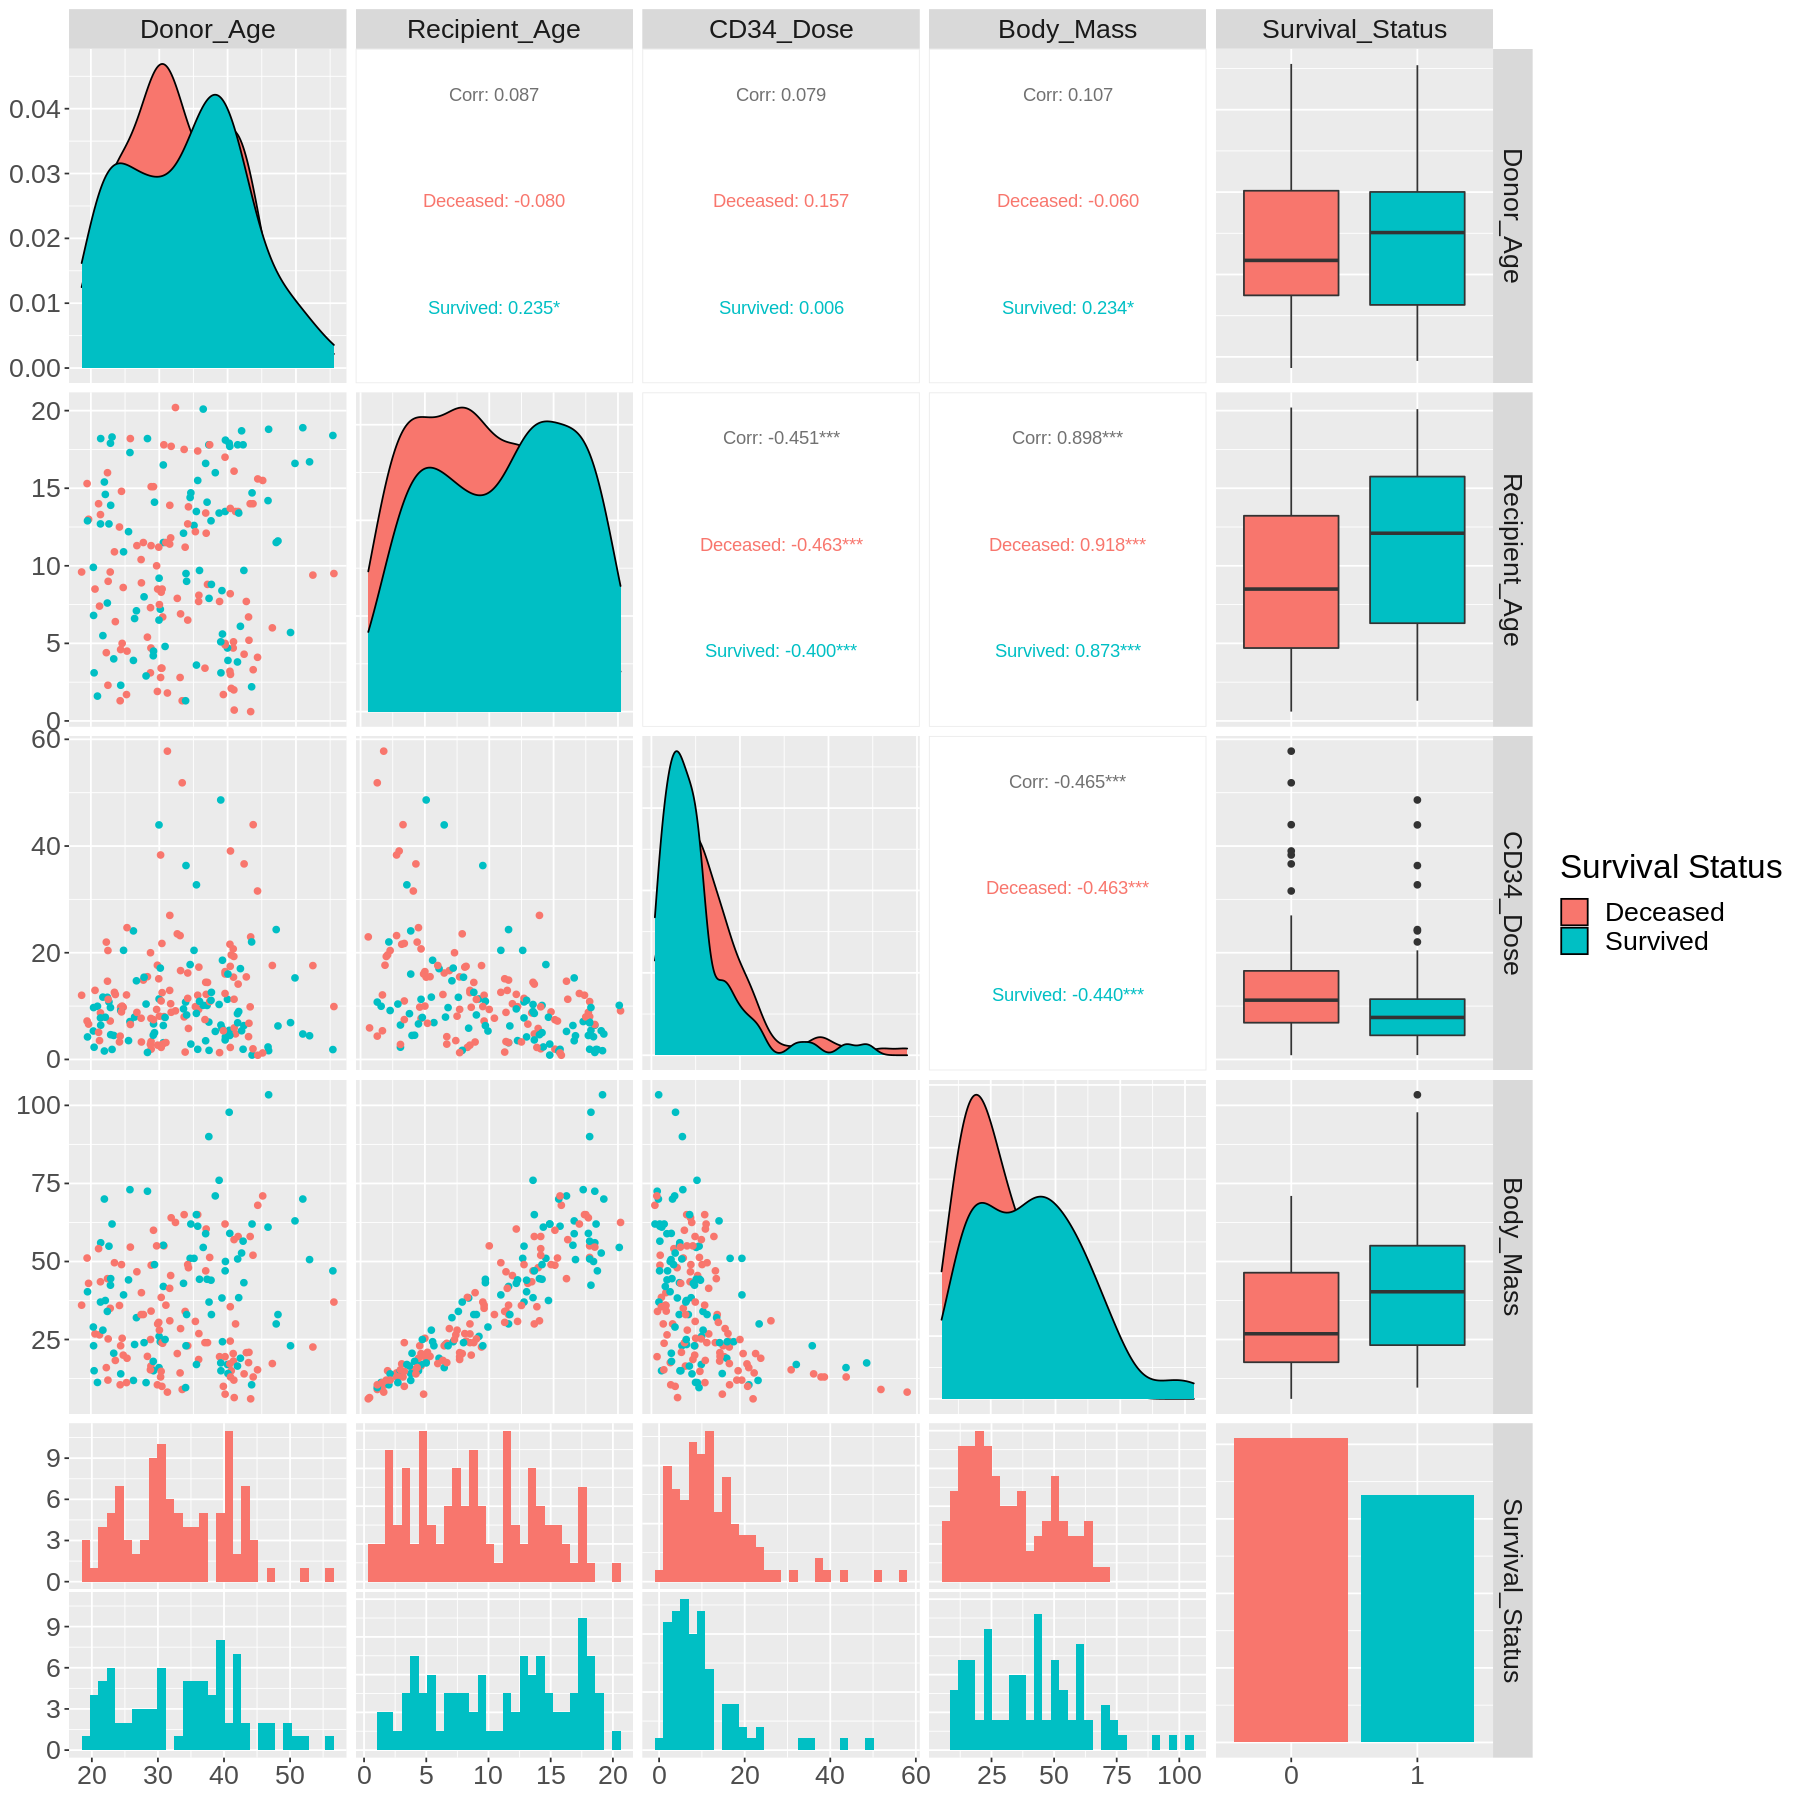

In [10]:
bone_marrow_clean |> ggpairs( legend = 1, 
                   aes(color = factor(Survival_Status, levels = 0:1, labels = c("Deceased", "Survived")))) + 
  theme(legend.position = "right",
       text = element_text(size = 20)) + 
  labs(fill = "Survival Status")

Here, we created graphs comparing each of our variables. We found that our predictors don't effectively distinguish between whether our patient will survive or not, but based on the box plots we find that theres a slight difference in the medians.

In [11]:
#preprocessing the data
knn_recipe <- recipe(Survival_Status ~ CD34_Dose + Body_Mass + Donor_Age + Recipient_Age, data = bone_marrow_train) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("classification") 

Since we found that the units and scales of our predictors are all different, we started out by standardizing our data using our training dataset. We used only the training dataset here in order to make sure that out testing data doesn't interfere with our accuracy.

After this, we trained our classifier by setting the numbers of k-neighbors to tune so that we can use cross-validation to find and pick the best k-value to maximize the accuracy.

In [12]:
bone_marrow_vfold <- vfold_cv(bone_marrow_train, v = 5, strata = Survival_Status)

k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))

knn_results <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = bone_marrow_vfold, grid = k_vals) |>
  collect_metrics() 

head(knn_results)

neighbors .metric  .estimator mean      n std_err    .config              
1 1         accuracy binary     0.5507845 5 0.03778157 Preprocessor1_Model01
2 1         roc_auc  binary     0.5487179 5 0.03802152 Preprocessor1_Model01
3 2         accuracy binary     0.5507845 5 0.03778157 Preprocessor1_Model02
4 2         roc_auc  binary     0.5366987 5 0.04745306 Preprocessor1_Model02
5 3         accuracy binary     0.5658639 5 0.02623108 Preprocessor1_Model03
6 3         roc_auc  binary     0.5395299 5 0.04047225 Preprocessor1_Model03

First, we divided our data into 5 equally sized folds and set our strata to our target variable, Survival Status, to ensure that the training and testing data had proportions of deceased and survived patients that were approximately representative of the overall dataset. We did this to make sure that we eliminate the chance of an unlucky validation set influencing our models accuracy.

Then, we created a tibble containing sample k-values from 1 to 25 to determine which k-value would yield the greatest accuracy.

Finally, we put everything together by combining both the recipe and the model specification into a workflow and then using tune_grid and collect_metrics to find and clearly show the accuracy for each of the k-values.

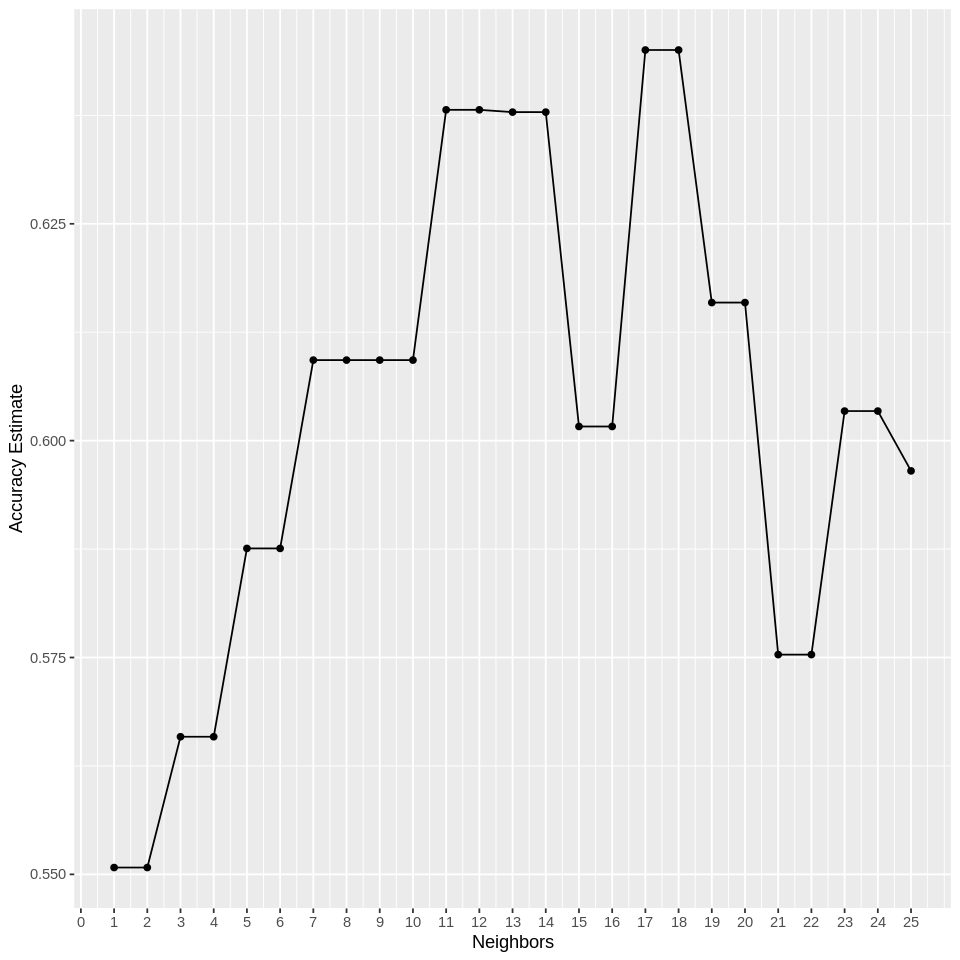

In [13]:
options(repr.plot.width = 8, repr.plot.height = 8)
accuracies <- knn_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 25, by = 1)) 

accuracy_versus_k

Here, we created a graph to visualize the the accuracies of each of the k-neighbors. We find that nearest neighbors of 18 give us the best accuracy. We chose this by finding the k-neighbors that have the highest chance of being accurate, which are 17 and 18, and then choosing the one that minimizes the accuracy when we add or subtract a neighbor.

In [14]:
bone_marrow_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 18) |>
       set_engine("kknn") |>
       set_mode("classification")

bone_marrow_fit_resamples <- workflow() |>
       add_recipe(knn_recipe) |>
       add_model(bone_marrow_spec_best) |>
       fit_resamples(resamples = bone_marrow_vfold)

We created a new specification by setting the neighbors to the best k-value, which we found was 18, and put it together with the recipe in a new workflow. We also included fit_resamples to make sure that each of the folds are cross-validated.

In [15]:
bone_marrow_metrics <- bone_marrow_fit_resamples |>
        collect_metrics() 
bone_marrow_metrics

.metric  .estimator mean      n std_err    .config             
1 accuracy binary     0.6450374 5 0.02610929 Preprocessor1_Model1
2 roc_auc  binary     0.5777991 5 0.05335997 Preprocessor1_Model1

We find that the accuracy of the folds is 64.5%.

In [16]:
bone_marrow_fit <- workflow() |>
       add_recipe(knn_recipe) |>
       add_model(bone_marrow_spec_best) |>
       fit(bone_marrow_train)

Finally, we fit the workflow with our recipe and the best specification model onto the training dataset.

In [23]:
bone_marrow_predictions <- predict(bone_marrow_fit, bone_marrow_test) |>
    bind_cols(bone_marrow_test)
head(bone_marrow_predictions)

.pred_class Donor_Age Recipient_Age CD34_Dose Body_Mass Survival_Status
1 0           22.83014   9.6           7.20     35.0      0              
2 1           39.68493  18.1           4.25     50.0      1              
3 0           33.35890   1.3          51.85      9.0      0              
4 0           21.43562  18.2           6.41     56.0      1              
5 1           28.78356   4.7           7.69     16.5      0              
6 0           29.73151   1.9          17.66     10.5      0

We used bone_marrow_fit to help predict the Survival Status of our observations from the testing dataset and display the testing dataset alongside the prediction colomn.

In [24]:
bone_marrow_test_accuracy <- bone_marrow_predictions |>
  metrics(truth = Survival_Status, estimate = .pred_class) |>
  filter(.metric == "accuracy")
bone_marrow_test_accuracy

.metric  .estimator .estimate
1 accuracy binary     0.5531915

We create a tibble to display the accuracy of our predictions by using the metric function and assigning truth to Survival Status and estimate to the .pred_class column. We find that the accuracy is 55.3%.

In [25]:
bone_marrow_confusion <- bone_marrow_predictions |>
             conf_mat(truth = Survival_Status, estimate = .pred_class)
bone_marrow_confusion

          Truth
Prediction  0  1
         0 18 13
         1  8  8

Here, we created a confusion matrix for our classifier using the actual Survival Status and the predictions of our model. We find that out of 47 observations, 26 were predicted correctly. 21 were predicted incorrectly, either classifying deceased as survived or survived when they were deceased.

### Discussion

We expected to find that we would would be able to accurately predict the Survival Status, but we found that there exists only a slight correlation between the different predictors that we used for our prediction and that it is somewhat possible to accurately predict the chances of survival of a patient based on these predictors. We also expected to find that as CD34+ stem cell dosage increases, chances of survival increase, however we found that there is no significant connection between the two. 

These findings show that further research must be done to determine the important factors for predicting patient survival post-transplant. It is paramount to adapt treatment regimens in order to improve survival outcomes for future patients. 

Future questions that our project could pose are:
* How can the chances of survival of future patients be improved?
* How can the donor’s compatibility with the recipient be optimized?

### References

Kałwak, Krzysztof, et al. “Higher CD34+ and CD3+ Cell Doses in the Graft Promote Long-Term Survival, and Have No Impact on the Incidence of Severe Acute or Chronic Graft-versus-Host Disease after In Vivo T Cell-Depleted Unrelated Donor Hematopoietic Stem Cell Transplantation in Children.” *Biology of Blood and Marrow Transplantation*, vol. 16, no. 10, 2010,         pp. 1388–1401, https://doi.org/10.1016/j.bbmt.2010.04.001. 

Sikora, Marek, and Lukasz Wrobel. “Bone Marrow Transplant: Children.” *UCI Machine 
Learning Repository*, 20 Apr. 2020, https://doi.org/10.24432/C5NP6Z. 

Sikora, Marek, et al. “Application of Rule Induction to Discover Survival Factors of 
Patients after Bone Marrow Transplantation.” *Journal of Medical Informatics & Technologies*, vol. 22, no. 2013, Jan. 2013. 